In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import matplotlib.ticker as mticker

In [12]:
import numba as nb

@nb.njit
def gen_mc_acf(tau,nsteps,tmatrix,mu,var,ppi):
	## Using a transition probability matrix, not a rate matrix, or Q matrix
	## because this comes straight out of an HMM.... so not quick exact

	nstates,_ = tmatrix.shape
	pi0 = np.eye(nstates)

	## get steady state probabilities
	pinf = np.linalg.matrix_power(tmatrix.T,100*int(1./tmatrix.min()))[:,0]

	## use fluctuations
	mubar =  (pinf*mu).sum()
	mm = mu - mubar

	### expectation here
	E_y0yt = np.zeros(nsteps)
	for i in range(nstates): # loop over initial state
		for j in range(nstates): # loop over final state
			for k in range(nsteps): # loop over time delay steps
				## E[y_0*t_t] = \sum_ij m_i * m_j * (A^n \cdot \delta (P_i))_j * P_inf,i
				E_y0yt[k] += mm[i]*mm[j] * (np.dot(np.linalg.matrix_power(tmatrix.T,k),pi0[i])[j]) * pinf[i]

	## add gaussian noise terms
	for i in range(nstates):
		E_y0yt[0] += var[i]*pinf[i]
	## normalize
	E_y0yt /= E_y0yt[0]

	t = tau*np.arange(nsteps)
	return t,E_y0yt

In [13]:
def return_params(dataset, snr,tsh=4):
    if dataset == 'reg':
        mu =  np.array([0.0, 1.])
        s =  np.array([1., 1.])/snr
        pi = np.array([0.6, 0.4])
        transition = np.array([
            [0.98, 0.02],
            [0.03, 0.97]])

        return mu, s, pi, transition
    
    elif dataset == 'dynamic2':
        mu =  np.array([0.0, 1., 0., 1.])
        s =  np.array([1., 1., 1., 1.])/snr
        pi = np.array([0.2, 0.4/3, 0.6, 0.4])
        pi /= pi.sum()
        
        t1 = np.array([            #slow 0-1
                [0.98, 0.02],
                [0.03, 0.97]])
        t2 = np.array([            #fast 0-1
                [0.94, 0.06],
                [0.09, 0.91]])
        t3 = np.array([            #slow-fast
                [1-0.0005*tsh/1., 0.0005*tsh/1.],
                [0.0005*tsh/1., 1-0.0005*tsh/1.]])

        transition = np.array([
            [t1[0][0]*t3[0][0], t1[0][1]*t3[0][0], t2[0][0]*t3[0][1], t2[0][1]*t3[0][1]],
            [t1[1][0]*t3[0][0], t1[1][1]*t3[0][0], t2[1][0]*t3[0][1], t2[1][1]*t3[0][1]],
            [t1[0][0]*t3[1][0], t1[0][1]*t3[1][0], t2[0][0]*t3[1][1], t2[0][1]*t3[1][1]],
            [t1[1][0]*t3[1][0], t1[1][1]*t3[1][0], t2[1][0]*t3[1][1], t2[1][1]*t3[1][1]]]) #replaced 3 with 1

        return mu, s, pi, transition
    
    elif dataset == 'static2':
        mu =  np.array([0.0, 1.])
        s =  np.array([1., 1.])/snr
        pi = np.array([0.6, 0.4])

        transition1 = np.array([
            [0.94, 0.06],
            [0.09, 0.91]])

        transition2 = np.array([
            [0.98, 0.02],
            [0.03, 0.97]])

        return mu, s, pi, transition1, transition2

In [14]:
def return_acf(dataset, t_max, snr, prop=None, tsh=4):
	if dataset in ['static2', 'static3']:
		if dataset == 'static2':
			mu, s, pi, transition1, transition2 = return_params(dataset,snr)
			t, acf1 = gen_mc_acf(1, t_max, transition1, mu, s**2, pi )
			t, acf2 = gen_mc_acf(1, t_max, transition2, mu, s**2, pi )
		else:
			mu1, s1, pi1, transition1, mu2, s2, pi2, transition2 = return_params(dataset,snr)
			t, acf1 = gen_mc_acf(1, t_max, transition1, mu1, s1**2, pi1 )
			t, acf2 = gen_mc_acf(1, t_max, transition2, mu2, s2**2, pi2 )

		acf = (prop[0]*acf1 + prop[1]*acf2)/prop.sum()

	else:
		mu, s, pi, transition = return_params(dataset,snr,tsh)

		t, acf = gen_mc_acf(1, t_max, transition, mu, s**2, pi )

	return t, acf

In [15]:
t_r, acf_r = return_acf('reg', 1000, 9.0, prop=None)

In [16]:
def compare_acf_truth(t, truth, col, lss, Es, acf_label = None, xlim = 650, save_name = None, figs = None):
    if figs is None:
        f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,3),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})
    else:
        f, (ax, ax2) = figs
    ax.set_xlim(-0., 1e-256)
    ax2.set_xlim(1, xlim)
    
    
    ax.plot(t_r,truth,label='Truth',color='grey',ls='-')
    ax2.plot(t_r,truth,label='Truth',color='grey',ls='-')
    
    mean = np.nanmean(Es, axis = 0)
    ax.plot(t_r, mean, color = col, ls = lss, label=acf_label)
    ax2.plot(t_r, mean, color = col, ls = lss, label=acf_label)
    ax2.legend(fontsize=8)
        
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(right = False, left=False) 

    ax.set_xscale('log')
    ax2.set_xscale('log')


    ax.set_ylabel('Normalised ACF')
    ax2.set_xlabel('Lag Time')
    if not save_name is None:
        plt.savefig(save_name)
    
    return f, (ax, ax2)

In [17]:
def lin_diff_acf(t, ref, acfs, cmap, tls, filcol,label=None,xlim=650, ylim=None, save_name = None, 
                       modshow=False,figs = None):
    if figs is None:
        f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,3),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})
    else:
        f, (ax, ax2) = figs
    ax.set_xlim(-0., 1e-256)
    ax2.set_xlim(1, xlim)
    if ylim is not None:
        ax2.set_ylim(ylim[0], ylim[1])
    
    residual_Es = -ref + np.array(acfs)
    x = np.unique(np.where(np.isfinite(residual_Es[:,1]))[0])
    mean_Es = np.nanmean(residual_Es[x], axis = 0)
    percentile_975 = np.nanpercentile(residual_Es[x], 97.5, axis = 0)
    percentile_025 = np.nanpercentile(residual_Es[x], 2.5, axis = 0)

    if modshow==True:
        for i in range(residual_Es.shape[0]):
            ax.plot(t_r, residual_Es[i], color='grey', alpha=0.05)
            ax2.plot(t_r, residual_Es[i], color='grey', alpha = 0.05) 

    ax.plot(t_r, mean_Es, color = cmap, ls = tls)
    ax2.plot(t_r, mean_Es, color = cmap, ls = tls, label = label)
    ax.fill_between(t_r, percentile_975, percentile_025, color = filcol, 
                     edgecolor=filcol, ls = tls, alpha=0.25)
    ax2.fill_between(t_r, percentile_975, percentile_025, color = filcol, 
                     edgecolor=filcol, ls = tls, alpha=0.25)
    
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(right = False, left=False) 

    ax.set_xscale('log')
    ax2.set_xscale('log')

    ax.set_ylabel('Residual')
    ax2.set_xlabel('Lag Time')
    if not save_name is None:
        plt.savefig(save_name)
    
    return f, (ax, ax2)

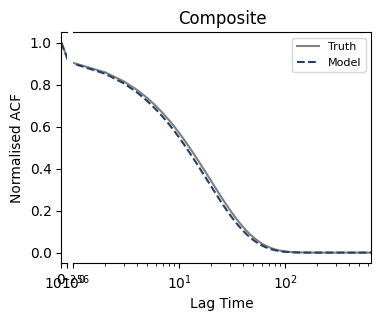

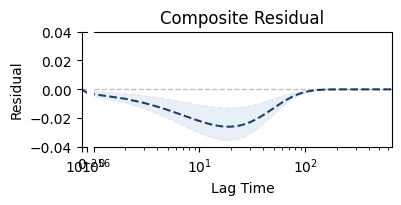

In [18]:
##Figure 3a LHS
Es_r9 = pickle.load(open( "results/ACFdicts_2_hom_9.0_composite_fixed.p", "rb" ))
compare_acf_truth(t_r, acf_r, '#20416a', '--', Es_r9['Fixed'], acf_label='Model')
plt.title('Composite')
plt.show()

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,1.5),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

lin_diff_acf(t_r, acf_r, Es_r9['Fixed'], '#20416a', '--','#a7c1e08c',figs=(f, (ax, ax2)))
ax.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.set_ylim(-0.04,0.04)
ax2.set_title('Composite Residual')
plt.show()

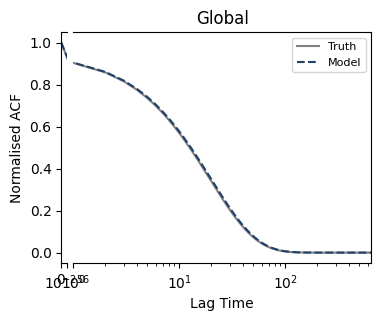

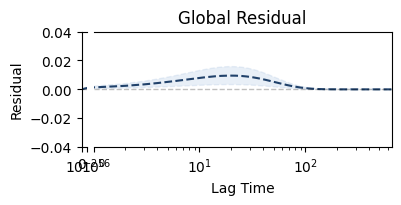

In [19]:
##Figure 3a RHS
Es_g_r9 = pickle.load(open( "results/ACFdicts_2_hom_9.0_global_fixed.p", "rb" ))
compare_acf_truth(t_r, acf_r, '#20416a', '--', Es_g_r9['Fixed'], acf_label='Model')
plt.title('Global')
plt.show()

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,1.5),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

lin_diff_acf(t_r, acf_r, Es_g_r9['Fixed'], '#20416a', '--','#a7c1e08c',figs=(f, (ax, ax2)))
ax.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.set_ylim(-0.04,0.04)
ax2.set_title('Global Residual')
plt.show()

In [20]:
def compare_models(t, truth, tcol, tls, Es, acf_label = None, xlim = 650, save_name = None, figs = None):
    if figs is None:
        f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,3),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})
    else:
        f, (ax, ax2) = figs
    ax.set_xlim(-0., 1e-256)
    ax2.set_xlim(1, xlim)
    
    ax.plot(t_r,truth,label='Truth',color='grey',ls='-')
    ax2.plot(t_r,truth,label='Truth',color='grey',ls='-')
    
    for i,E in enumerate(Es):    
        mean = np.nanmean(E, axis = 0)
        ax.plot(t_r, mean, color = tcol, ls = tls[i], label=acf_label[i])
        ax2.plot(t_r, mean, color = tcol, ls = tls[i], label=acf_label[i])
        ax2.legend(fontsize=8)
        
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(right = False, left=False) 

    ax.set_xscale('log')
    ax2.set_xscale('log')


    ax.set_ylabel('Normalised ACF')
    ax2.set_xlabel('Lag Time')
    if not save_name is None:
        plt.savefig(save_name)
    
    return f, (ax, ax2)

In [21]:
def lin_diff_models(t, ref, Es, cmap, tls, filcol,label=None,xlim=650, ylim=None, save_name = None, 
                       figs = None):
    if figs is None:
        f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,3),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})
    else:
        f, (ax, ax2) = figs
    ax.set_xlim(-0., 1e-256)
    ax2.set_xlim(1, xlim)
    if ylim is not None:
        ax2.set_ylim(ylim[0], ylim[1])
    
    for i,E in enumerate(Es):
        residual_Es = -ref + np.array(E)
        x = np.unique(np.where(np.isfinite(residual_Es[:,1]))[0])
        mean_Es = np.nanmean(residual_Es[x], axis = 0)
        percentile_975 = np.nanpercentile(residual_Es[x], 97.5, axis = 0)
        percentile_025 = np.nanpercentile(residual_Es[x], 2.5, axis = 0)

        ax.plot(t_r, mean_Es, color = cmap, ls = tls[i])
        ax2.plot(t_r, mean_Es, color = cmap, ls = tls[i], label = label[i])
        ax.fill_between(t_r, percentile_975, percentile_025, color = filcol, 
                         edgecolor=filcol, ls = tls[i], alpha=0.25)
        ax2.fill_between(t_r, percentile_975, percentile_025, color = filcol, 
                         edgecolor=filcol, ls = tls[i], alpha=0.25)
    
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(right = False, left=False) 

    ax.set_xscale('log')
    ax2.set_xscale('log')

    ax.set_ylabel('Residual')
    ax2.set_xlabel('Lag Time')
    if not save_name is None:
        plt.savefig(save_name)
    
    return f, (ax, ax2)

Text(0.5, 1.0, 'Global ChangeT Residual')

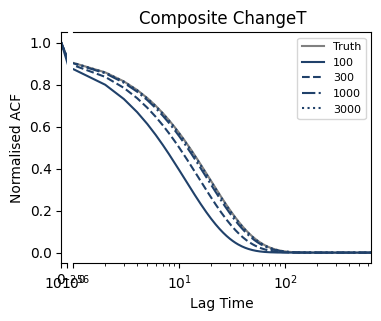

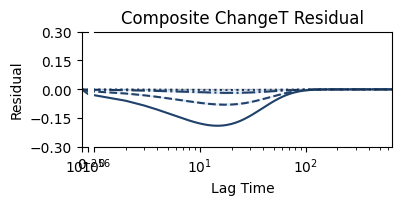

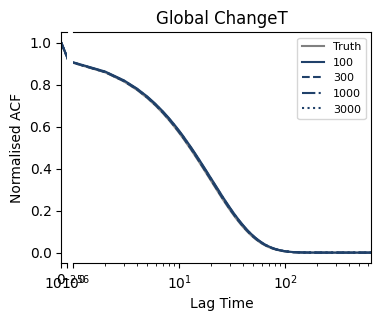

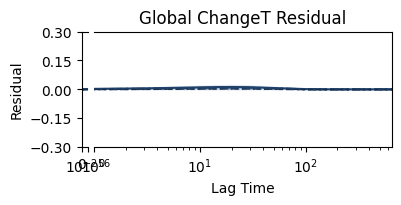

In [22]:
#Figure 3b Top Row
f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,3),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

lss = ["-","--","-.",":"]
acf_label = ['100','300','1000','3000']
Edict_r9_T = pickle.load(open( "results/ACFdicts_2_hom_9.0_composite_changeT.p", "rb" ))
Es = [Edict_r9_T[100],Edict_r9_T[300],Edict_r9_T[1000],Edict_r9_T[3000]]
compare_models(t_r, acf_r, '#20416a', lss, Es, acf_label, figs=(f, (ax, ax2)))
plt.title('Composite ChangeT')
ax2.legend(fontsize=8)

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,1.5),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})


lin_diff_models(t_r, acf_r, Es, '#20416a', lss,'#a7c1e08c',acf_label,figs=(f, (ax, ax2)))
    
ax.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
plt.yticks(np.arange(-0.3,0.45, step=0.15))
ax2.set_ylim(-0.3,0.3)
plt.title('Composite ChangeT Residual')

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,3),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

lss = ["-","--","-.",":"]
acf_label = ['100','300','1000','3000']
Edict_r9_gT = pickle.load(open( "results/ACFdicts_2_hom_9.0_global_changeT.p", "rb" ))
Es = [Edict_r9_gT[100],Edict_r9_gT[300],Edict_r9_gT[1000],Edict_r9_gT[3000]]
compare_models(t_r, acf_r, '#20416a', lss, Es, acf_label, figs=(f, (ax, ax2)))
plt.title('Global ChangeT')
ax2.legend(fontsize=8)

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,1.5),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})


lin_diff_models(t_r, acf_r, Es, '#20416a', lss,'#a7c1e08c',acf_label,figs=(f, (ax, ax2)))
    
ax.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
plt.yticks(np.arange(-0.3,0.45, step=0.15))
ax2.set_ylim(-0.3,0.3)
plt.title('Global ChangeT Residual')

Text(0.5, 1.0, 'Global ChangeN Residual')

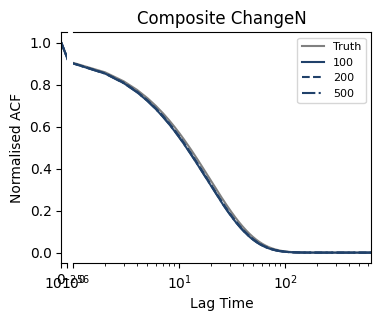

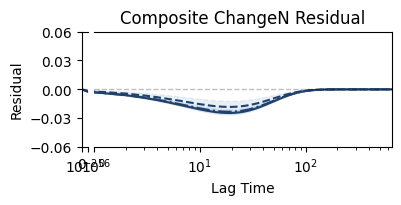

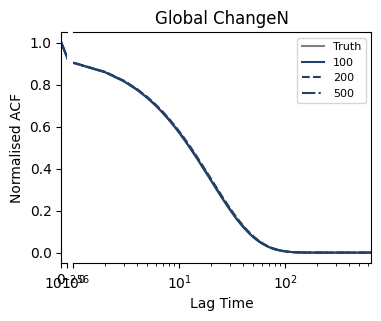

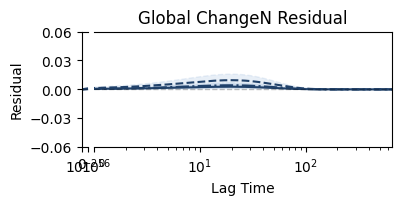

In [23]:
#Figure 3b Bottom Row
f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,3),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

lss = ["-","--","-."]
acf_label = ['100','200','500']
Edict_r9_N = pickle.load(open( "results/ACFdicts_2_hom_9.0_composite_changeN.p", "rb" ))
Es = [Edict_r9_N[100],Edict_r9_N[200],Edict_r9_N[500]]
compare_models(t_r, acf_r, '#20416a', lss, Es, acf_label, figs=(f, (ax, ax2)))
ax2.legend(fontsize=8)
plt.title('Composite ChangeN')

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,1.5),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

lin_diff_models(t_r, acf_r, Es, '#20416a', lss,'#a7c1e08c',acf_label,figs=(f, (ax, ax2)))
    
ax.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
plt.yticks(np.arange(-0.06,0.09, step=0.03))
ax2.set_ylim(-0.06,0.06)
plt.title('Composite ChangeN Residual')

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,3),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})


lss = ["-","--","-."]
acf_label = ['100','200','500']
Edict_r9_gN = pickle.load(open( "results/ACFdicts_2_hom_9.0_global_changeN.p", "rb" ))
Es = [Edict_r9_gN[100],Edict_r9_gN[200],Edict_r9_gN[500]]
compare_models(t_r, acf_r, '#20416a', lss, Es, acf_label, figs=(f, (ax, ax2)))
ax2.legend(fontsize=8)
plt.title('Global ChangeN')

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,1.5),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

lin_diff_models(t_r, acf_r, Es, '#20416a', lss,'#a7c1e08c',acf_label,figs=(f, (ax, ax2)))
    
ax.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
plt.yticks(np.arange(-0.06,0.09, step=0.03))
ax2.set_ylim(-0.06,0.06)
plt.title('Global ChangeN Residual')

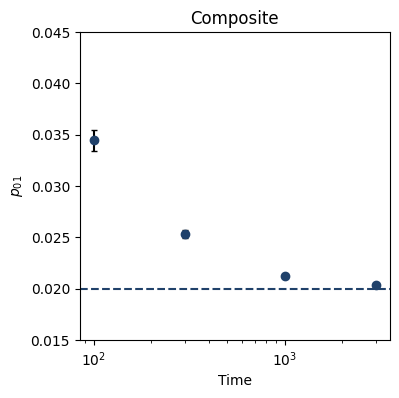

<Figure size 400x400 with 0 Axes>

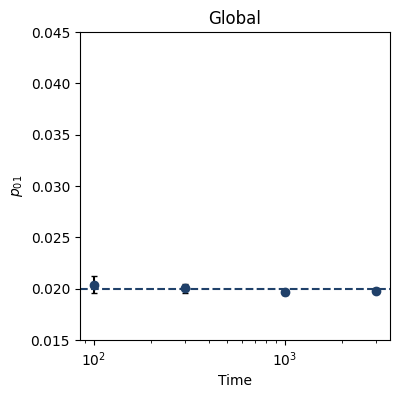

In [24]:
#Figure 4a 
resdict_r9_T = pickle.load(open( "results/Resultdicts_2_hom_9.0_composite_changeT.p", "rb" ))
tmatrixs_com_d = {}
for j in [100,300,1000,3000]:
    tmatrixs_com_d[j] = []
    for i in resdict_r9_T[j]:
        #if i.tmstar[0,1] > 0.005 and i.tmstar[1,0] > 0.01:
        tmatrixs_com_d[j].append(i.tmstar)
    tmatrixs_com_d[j] = np.array(tmatrixs_com_d[j])

fig,ax = plt.subplots(figsize=(4,4))
for j in [100,300,1000,3000]:
    ax.errorbar(x = j, y = np.mean(tmatrixs_com_d[j][:,0,1]), 
                 yerr = np.std(tmatrixs_com_d[j][:,0,1]),
                 fmt='o', color = '#20416a', ecolor = 'k', capsize = 2)
plt.axhline(y = 0.02, ls = '--',color ='#20416a',alpha = 1)

plt.title('Composite')
plt.xlabel('Time')
plt.ylabel('$p_{01}$')
ax.set_xscale('log') 
ax.set_ylim(.015, .045)
plt.show()

resdict_r9_gT = pickle.load(open( "results/Resultdicts_2_hom_9.0_global_changeT.p", "rb" ))
plt.figure(figsize=(4,4))
tmatrixs_glo_d = {}
for j in [100,300,1000,3000]:
    tmatrixs_glo_d[j] = []
    for i in resdict_r9_gT[j]:
        #if i.tmstar[0,1] > 0.005 and i.tmstar[1,0] > 0.01:
        tmatrixs_glo_d[j].append(i.tmstar)
    tmatrixs_glo_d[j] = np.array(tmatrixs_glo_d[j])
    
fig,ax = plt.subplots(figsize=(4,4))
for j in [100,300,1000,3000]:
    ax.errorbar(x = j, y = np.mean(tmatrixs_glo_d[j][:,0,1]), 
                 yerr = np.std(tmatrixs_glo_d[j][:,0,1]),
                 fmt='o', color = '#20416a', ecolor = 'k', capsize = 2)
plt.axhline(y = 0.02, ls = '--',color ='#20416a',alpha = 1)

plt.title('Global')
plt.xlabel('Time')
plt.ylabel('$p_{01}$')
ax.set_xscale('log') 
ax.set_ylim(.015, .045)
plt.show()


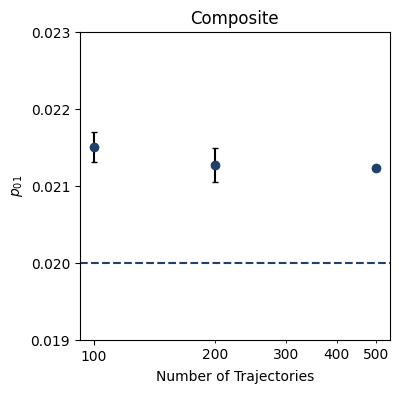

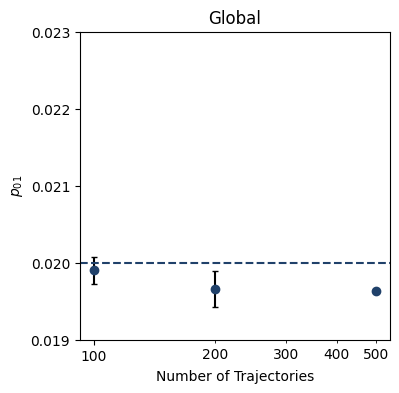

In [25]:
#Figure 4b
resdict_r9_N = pickle.load(open( "results/Resultdicts_2_hom_9.0_composite_changeN.p", "rb" ))
tmatrixs_com_d = {}
for j in [100,200,500]:
    tmatrixs_com_d[j] = []
    for i in resdict_r9_N[j]:
        #if i.tmstar[0,1] > 0.005 and i.tmstar[1,0] > 0.01:
        tmatrixs_com_d[j].append(i.tmstar)
    tmatrixs_com_d[j] = np.array(tmatrixs_com_d[j])

fig,ax = plt.subplots(figsize=(4,4))
for j in [100,200,500]:
    ax.errorbar(x = j, y = np.mean(tmatrixs_com_d[j][:,0,1]), 
                 yerr = np.std(tmatrixs_com_d[j][:,0,1]),
                 fmt='o', color = '#20416a', ecolor = 'k', capsize = 2)
plt.axhline(y = 0.02, ls = '--',color ='#20416a',alpha = 1)

plt.title('Composite')
plt.xlabel('Number of Trajectories')
plt.ylabel('$p_{01}$')
ax.set_xscale('log') 
plt.yticks(np.arange(0.016, 0.026, step=0.001))
ax.set_ylim(.019, .023)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())

resdict_r9_gN = pickle.load(open( "results/Resultdicts_2_hom_9.0_global_changeN.p", "rb" ))
tmatrixs_glo_d = {}
for j in [100,200,500]:
    tmatrixs_glo_d[j] = []
    for i in resdict_r9_gN[j]:
        #if i.tmstar[0,1] > 0.005 and i.tmstar[1,0] > 0.01:
        tmatrixs_glo_d[j].append(i.tmstar)
    tmatrixs_glo_d[j] = np.array(tmatrixs_glo_d[j])

fig,ax = plt.subplots(figsize=(4,4))
for j in [100,200,500]:
    ax.errorbar(x = j, y = np.mean(tmatrixs_glo_d[j][:,0,1]), 
                 yerr = np.std(tmatrixs_glo_d[j][:,0,1]),
                 fmt='o', color = '#20416a', ecolor = 'k', capsize = 2)
plt.axhline(y = 0.02, ls = '--',color ='#20416a',alpha = 1)

plt.title('Global')
plt.xlabel('Number of Trajectories')
plt.ylabel('$p_{01}$')
ax.set_xscale('log') 
plt.yticks(np.arange(0.016, 0.026, step=0.001))
ax.set_ylim(.019, .023)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())